# Event Centering 2021-04-14

Goal of this notebook is to test out functions for event centering on 1 day, 1 neuron. And then, 1 day, all neurons. And then all days all neurons. Plan is to save out as dicts (nested) to used for later analysis specific to delay period analysis.

### Libs & Utils

In [1]:
# libraries
import sys; sys.path.insert(0, '..') # if you don't find it here, look one above
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio
import pickle
from tqdm import tqdm
from scipy import stats
# stored one repo up in my fork of Spykes
# from spykes.spykes.plot.neurovis import NeuroVis
from io_utils import *
from plotting_utils import * 


# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

### Load session

Here, I'm loading in one session (08-06-2019) that has 4 cells 

In [121]:
sess_name = 'W122_08_06_2019_1_fromSD'

base_path  = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata' 
beh_mat   = 'protocol_info.mat'
spks_mat  = 'ksphy_clusters_foranalysis.mat'

# create paths
sess_path = os.path.join(base_path, sess_name)
beh_path  = os.path.join(sess_path, beh_mat)
spks_path = os.path.join(sess_path, spks_mat)
# fig_save_path = os.path.join(os.getcwd(), 'figures', 'neurovis', sess_name)

# alginment info (hard coded here & in fx)
names = ['aud1on', 'aud1off', 'aud2on', 'aud2off', 'trial_all', 
         'delay2s', 'trial2s', 'delay4s', 'trial4s']
windows = [[-400, 600], [-500, 500], [-400, 600], [-500, 500], [-100, 5000],
           [-150, 2150],[-200, 2400], [-150, 4150], [-200, 4400]]

align_windows = dict(zip(names,windows))


# load & wrangle
beh_df, spks_dict = load_and_wrangle(beh_path, spks_path, overwrite=False)
sess_aligned = event_align_session(spks_dict, beh_df, sess_path, overwrite=False)

loading from file...


In [122]:
align_windows

{'aud1on': [-400, 600],
 'aud1off': [-500, 500],
 'aud2on': [-400, 600],
 'aud2off': [-500, 500],
 'trial_all': [-100, 5000],
 'delay2s': [-150, 2150],
 'trial2s': [-200, 2400],
 'delay4s': [-150, 4150],
 'trial4s': [-200, 4400]}

In [123]:
sess_aligned[0].keys()

dict_keys(['aud1on', 'aud1off', 'aud2on', 'aud2off', 'trial_all', 'delay2s', 'trial2s', 'delay4s', 'trial4s'])

In [172]:
neuron_t = split_spks_by_trial(spks_dict['spk_times'][0], beh_df)
neuron_a = sess_aligned[1]

In [216]:
# beh_df.loc[:, 'hit_hist'].values == 'hit'

### Rasters

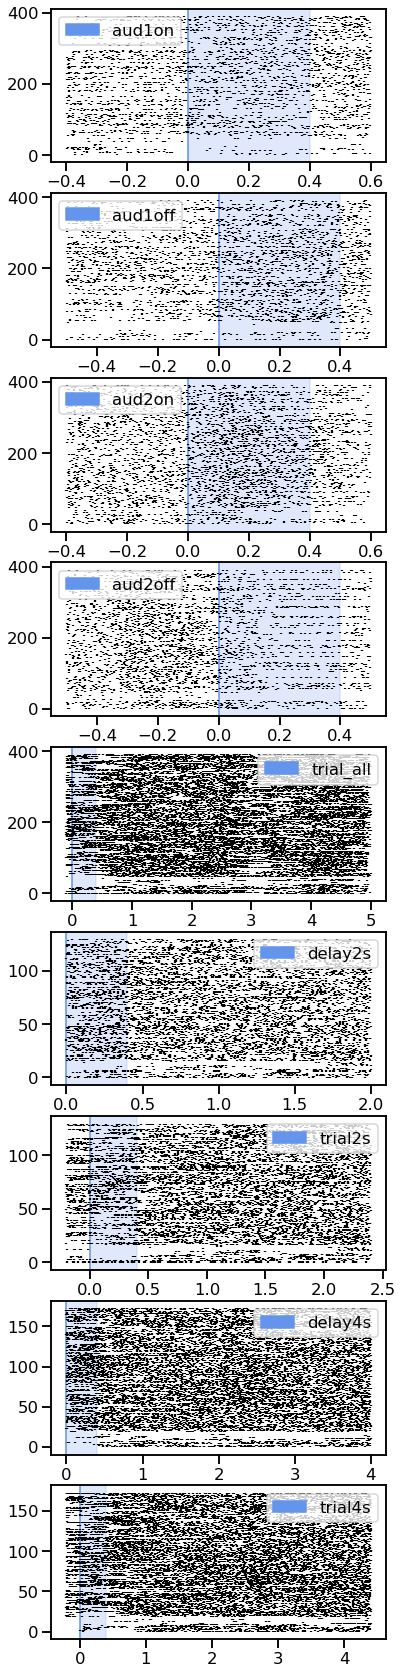

In [65]:
fig, ax = plt.subplots(len(neuron_a), 1, figsize=(6,30))

for idx, key in enumerate(neuron_a.keys()):
    _ = ax[idx].eventplot(neuron_a[key],colors = 'black')
    ax[idx].axvspan(0,0.000001, color = 'cornflowerblue', label = key)
    ax[idx].axvspan(0,0.4, alpha = 0.2, color = 'cornflowerblue')
    ax[idx].legend()
    

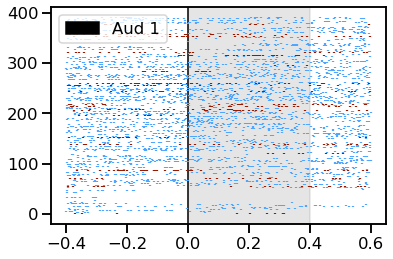

In [111]:
t = (beh_df['hit_hist'] =='hit').to_numpy()
new = np.where(t == True, '#4DA6FF', '#991900')

_ = plt.eventplot(neuron_a['aud1on'], color = new)
plt.axvspan(0,0.4, alpha = 0.2, color = 'grey')
plt.axvspan(0,0.000001, color = 'black', label = 'Aud 1')
plt.legend()

### PSTHs

Stopped here--- TODO:
* turn plotting & PSTHs by condition into function
* expand to multiple events
* expand to splitting by conditions
* expand to multiple neurons
* expand to multiple sessions

In [181]:
test = binarize_event(sess_aligned[2]['delay2s'],[-150,2150], 0.001)
mu = 0
sigma = .150
x = np.linspace(-1.0, 1.0, 150)
ker = make_gaussian_kernal(x, mu, sigma)

# make kernal
kernal = make_gaussian_kernal(x, mu, sigma)

# convolve 
m, s, tr = smooth_trials(test, kernal, summary=True)
# for plot
time = np.linspace(-150, 2150, len(m))


No handles with labels found to put in legend.


(0.0, 2000.0)

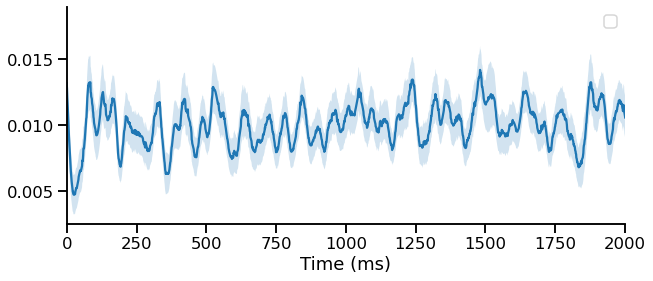

In [175]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(time, m)
ax.fill_between(time, m - s, m + s, alpha = 0.2 )

# plt.axvspan(0,400, alpha = 0.2, color = 'grey')
# plt.axvspan(0,0.000001, color = 'black', label = 'Aud 1')
ax.set(xlabel = "Time (ms)")
plt.legend()
sns.despine()
plt.xlim(0,2000)
# plt.ylim(0.01, 0.05)

### make into fx

Note: for delay plots, will want to save the mean firing rate as well to make another mean. So maybe so something like spykes where raster saves out and plot option can be toggled

In [148]:
beh_df_2s.head()

,trial_num,hit_hist,delay,pair_hist,correct_side,prev_side,aud1_sigma,aud2_sigma,c_poke,end_state,hit_state,aud1_on,aud1_off,aud2_on,aud2_off,louder,first_sound
0,15,hit,2,4,RIGHT,LEFT,0.053144,0.019683,519.086082,524.267078,523.067086,519.136082,519.536082,521.536087,521.936083,aud_1,0.0531*
4,20,hit,2,1,RIGHT,LEFT,0.002700,0.001000,570.250080,575.399077,574.317085,570.300083,570.700080,572.701084,573.100081,aud_1,0.0027
6,23,hit,2,1,RIGHT,RIGHT,0.002700,0.001000,596.990080,602.193083,601.003078,597.041082,597.441072,599.441076,599.841086,aud_1,0.0027
15,33,hit,2,7,LEFT,RIGHT,0.007290,0.019683,701.775077,707.133076,705.833081,701.825079,702.226089,704.225089,704.625079,aud_2,0.0073
20,39,hit,2,7,LEFT,RIGHT,0.007290,0.019683,764.498082,769.665077,768.386080,764.549088,764.949080,766.948089,767.349082,aud_2,0.0073


In [185]:
beh_df_2s = beh_df[(beh_df['delay'] == 2)
       & (beh_df['first_sound'] != 'psycho')]

event = 'delay2s'
conditions = 'first_sound'

trials = dict()
for cond_id in np.sort(beh_df_2s[conditions].unique()):
    
    trials[cond_id] = np.where((beh_df_2s[conditions] == cond_id).values)[0]

PSTH = {'event' : event, 'conditions' : conditions, 'N': [], 'time' : [], 'data' : {}, 'mean' : {}, 'sem' :{}}

for cond_id, idxs in trials.items():
    
    # grab the trials for each condition
    selected_trials = test[idxs]
    PSTH['N'].append(len(selected_trials))
    
    # convolve
    mean, sem, data = smooth_trials(selected_trials, kernal, summary=True)
    
    PSTH['data'][cond_id] = data
    PSTH['mean'][cond_id] = mean
    PSTH['sem'][cond_id] = sem
    
    PSTH['time'].append(np.linspace(align_windows[event][0], 
                                    align_windows[event][1],
                                    len(PSTH['mean'][cond_id])))
    
    

(0.02185903135708674, 0.10940863535803734)

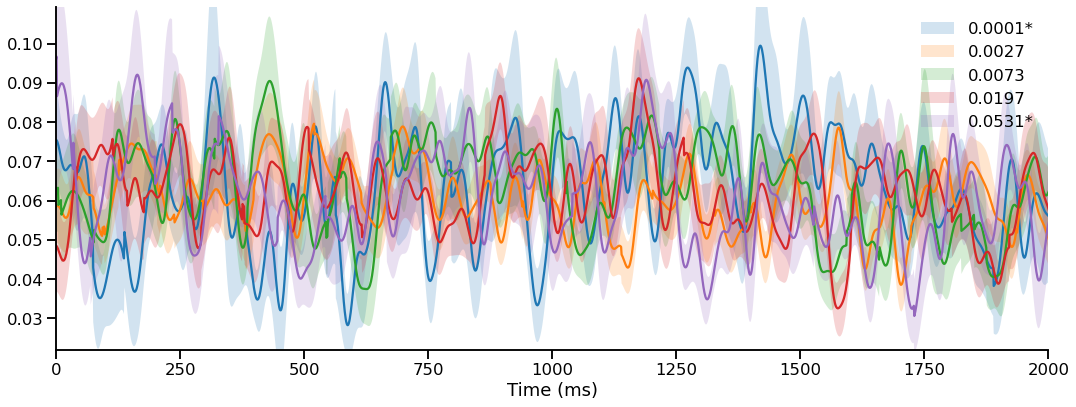

In [201]:
fig, ax = plt.subplots(figsize = (15, 6))

for cond_id in PSTH['mean'].keys():
    ax.plot(PSTH['time'][0], PSTH['mean'][cond_id])
    ax.fill_between(PSTH['time'][0], PSTH['mean'][cond_id] - PSTH['sem'][cond_id],
                    PSTH['mean'][cond_id] + PSTH['sem'][cond_id], alpha = 0.2,label = cond_id )

# aestetics 
# plt.axvspan(0,400, alpha = 0.2, color = 'grey')
# plt.axvspan(0,0.000001, color = 'black')
ax.set(xlabel = "Time (ms)")
plt.legend(frameon=False)
sns.despine()
plt.tight_layout()
plt.xlim(0,2000)

scale = 0.1
y_min = (1.0 - scale) * np.nanmin([np.min(PSTH['mean'][psth_idx])
            for psth_idx in PSTH['data'].keys()])
y_max = (1.0 + scale) * np.nanmax([np.max(PSTH['mean'][psth_idx])
            for psth_idx in PSTH['data'].keys()])

ax.set_ylim([y_min, y_max])

[0.09946239578003394,
 0.07958246049480691,
 0.09047741352753191,
 0.09116004330142309,
 0.09670418400268523]

In [195]:
for psth_idx in PSTH['data'].keys():
    print(psth_idx)

0.0001*
0.0027
0.0073
0.0197
0.0531*


In [197]:
PSTH['mean']

{'0.0001*': array([0.02726245, 0.02873723, 0.03011698, ..., 0.0434121 , 0.04124819,
        0.03902593]),
 '0.0027': array([0.03091256, 0.0328585 , 0.03477014, ..., 0.03928038, 0.03717172,
        0.03500693]),
 '0.0073': array([0.03257367, 0.0350181 , 0.03745987, ..., 0.02790319, 0.02608595,
        0.02428781]),
 '0.0197': array([0.04140509, 0.04398641, 0.04645949, ..., 0.04627988, 0.04462583,
        0.04278062]),
 '0.0531*': array([0.0260237 , 0.02783259, 0.02963634, ..., 0.0302203 , 0.02750813,
        0.02490697])}

In [ ]:
np.max(PSTH['data']['0.0001*']'')

I want to now take the PSTH dict output above and make the plot that carlos has asked for with first sound on x axis and average firing rate on y axis.

Update: this is okay, but I should probably do it for each cond and store (ie from data not from mean) to get a better idea of waht is going on. Ideally, this could be stored in a df for using seaborn..?

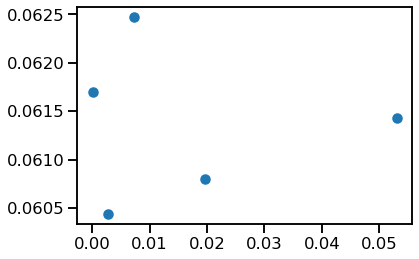

In [190]:
means = PSTH['mean']
label = []
avg = []
for key, val in means.items():
    
    key = key.replace('*','')
    label.append(float(key))
    
    avg.append(np.mean(val))

plt.scatter(label, avg)

## non function code

#### scipy stats

seems not to work when y axis output is < 1 

In [59]:
# these are names in the beh_df
df_event = ['aud1_on', 'aud1_off', 'aud2_on', 'aud2_off', 'aud1_on']
names = ['aud1on', 'aud1off', 'aud2on', 'aud2off', 'trial_all']
windows = [[-400, 600], [-500, 500], [-400, 600], [-500, 500], [-100, 5000]]


aligned_spk_times = {}

for event,name,window in zip(df_event,names,windows):
    rowsL = []
    aligned_spk_times[name] = []
    
    for itrial, row in beh_df.iterrows():
        
        trial_spks = neuron1_spks['trial_spks'][itrial]

        # grab alignment time
        align_time = row[event]
        
        # create windows
        start = align_time + (window[0] * 0.001)
        stop  = align_time + (window[1] * 0.001)  
        
         # grab spks in the window
        spks_in_window = trial_spks[np.logical_and(trial_spks > start, trial_spks < stop)]
        event_aligned = spks_in_window - align_time
        
        # append
        aligned_spk_times[name].append(event_aligned)
        

In [102]:
# delay

def delay_align(beh_df, trial_spks):
    delay_windows = [[0, 2000],[-200, 2400], [0, 4000], [-200, 4400]]
    delay_names = ['delay2s', 'trial2s', 'delay4s', 'trial4s']


L =[[],[],[],[]]


    for itrial, row in beh_df.iterrows():

        trial_spks = neuron1_spks['trial_spks'][itrial]
        d_align_time = row['aud1_off']
        t_align_time = row['aud1_on']

        if row['delay'] == 2:

            d = 0
            d_start  = d_align_time + (delay_windows[d][0] * 0.001)
            d_stop   = d_align_time + (delay_windows[d][1] * 0.001)

            spks_in_delay = trial_spks[np.logical_and(trial_spks > d_start, trial_spks < d_stop)]
            delay_aligned = spks_in_delay - d_align_time
            L[d].append(delay_aligned)

            t = 1
            t_start  = t_align_time + (delay_windows[t][0] * 0.001)
            t_stop   = t_align_time + (delay_windows[t][1] * 0.001)

            spks_in_trial = trial_spks[np.logical_and(trial_spks > t_start, trial_spks < t_stop)]
            trial_aligned = spks_in_trial - t_align_time
            L[t].append(trial_aligned)

        elif row['delay'] == 4:

            d = 2 
            d_start  = d_align_time + (delay_windows[d][0] * 0.001)
            d_stop   = d_align_time + (delay_windows[d][1] * 0.001)

            spks_in_delay = trial_spks[np.logical_and(trial_spks > d_start, trial_spks < d_stop)]
            delay_aligned = spks_in_delay - d_align_time
            L[d].append(delay_aligned)

            t = 3
            t_start  = t_align_time + (delay_windows[t][0] * 0.001)
            t_stop   = t_align_time + (delay_windows[t][1] * 0.001)

            spks_in_trial = trial_spks[np.logical_and(trial_spks > t_start, trial_spks < t_stop)]
            trial_aligned = spks_in_trial - t_align_time
            L[t].append(trial_aligned)


    delay_info = dict(zip(delay_names, L))